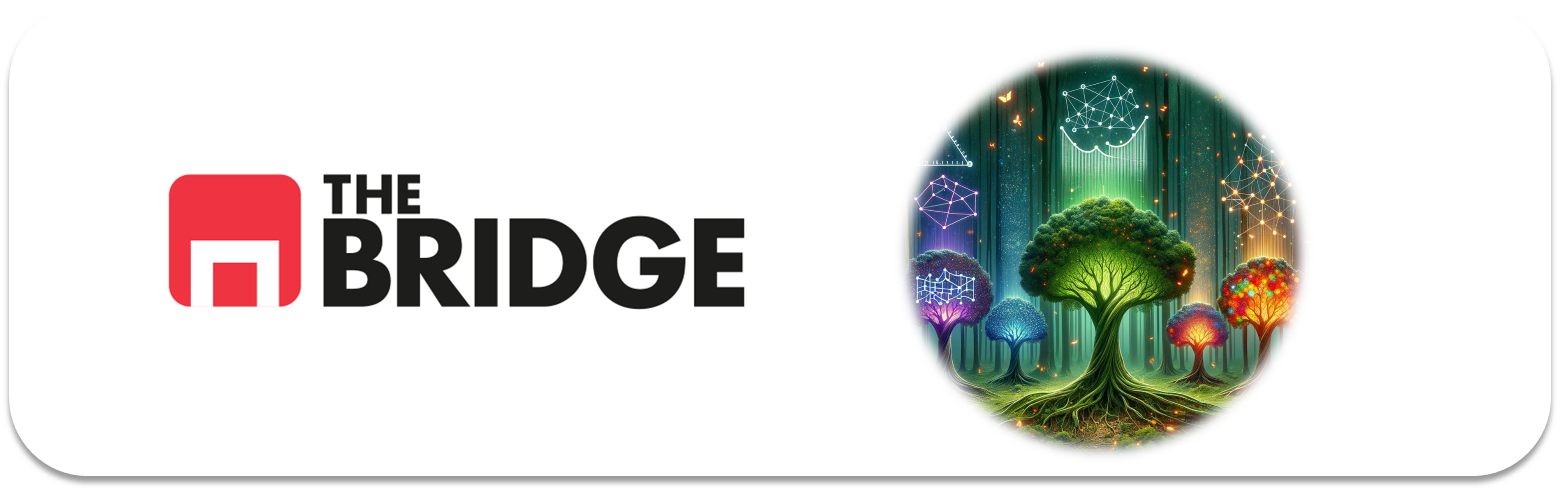

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de Hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Importar tus herramientas personalizadas
from bootcampviztools import *

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline

from bootcampviztools import *

In [2]:
df = pd.read_csv('./data/bank-full.csv', sep=';')

Distribución del Target:
     Cantidad  Porcentaje
y                        
no      39922    0.883015
yes      5289    0.116985


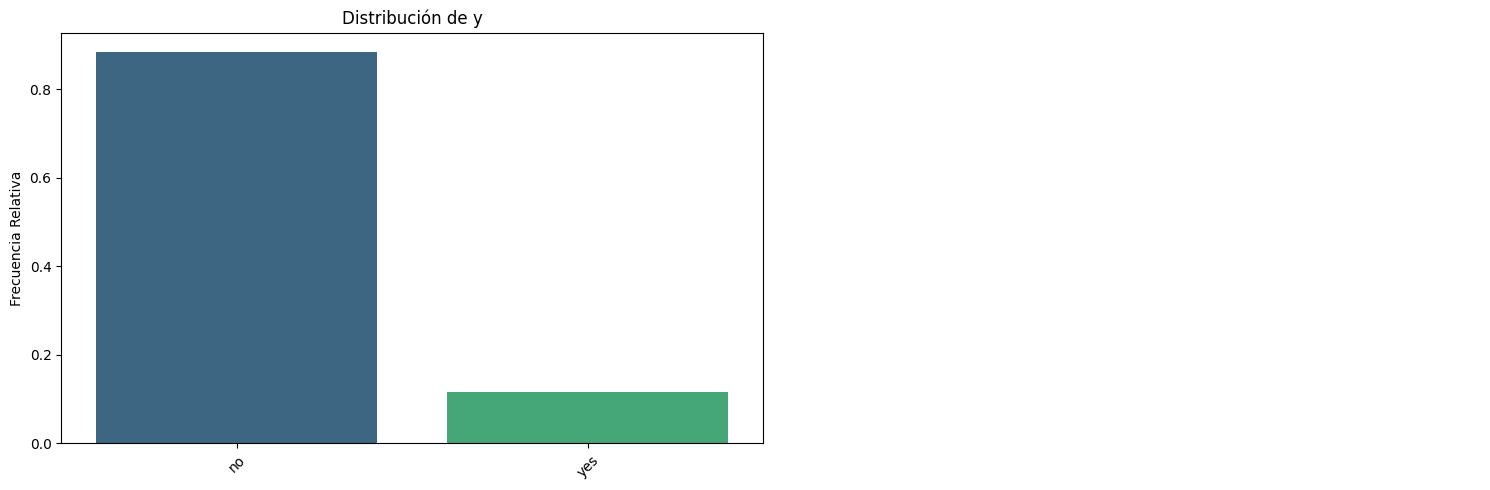

In [3]:
target = 'y'

counts = df[target].value_counts()
relative = df[target].value_counts(normalize=True)

print("Distribución del Target:")
print(pd.DataFrame({'Cantidad': counts, 'Porcentaje': relative}))

pinta_distribucion_categoricas(df, [target], relativa=True)

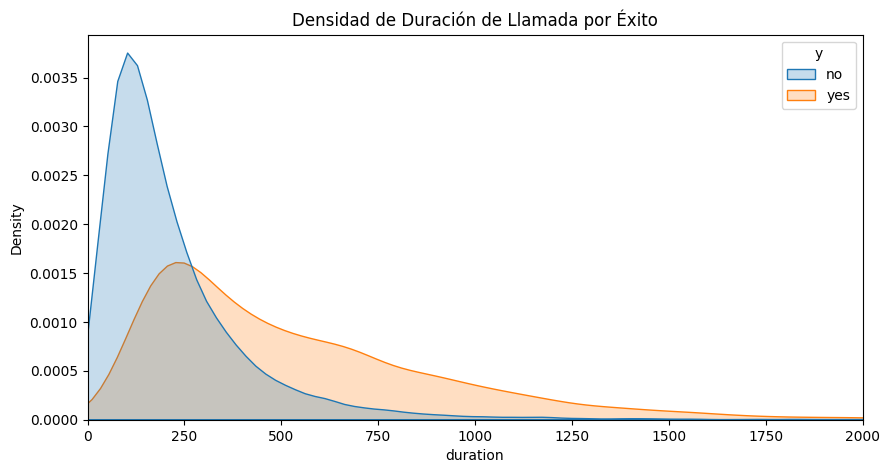

In [ ]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='duration', hue='y', fill=True, common_norm=False)
plt.title('Densidad de Duración de Llamada por Éxito')
plt.xlim(0, 2000)
plt.show()

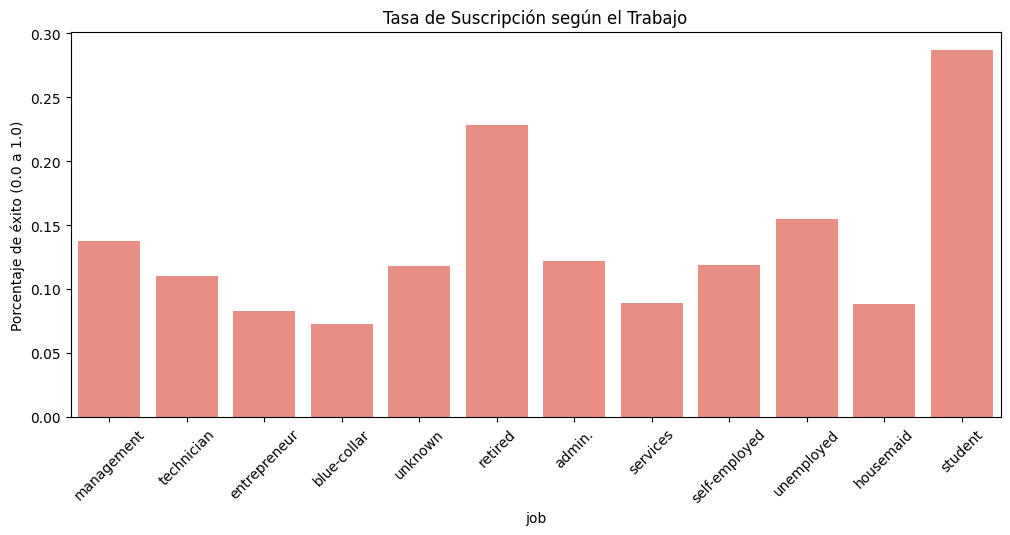

In [5]:
plt.figure(figsize=(12, 5))
sns.barplot(data=df, x='job', y=(df['y'] == 'yes').astype(int), color='salmon', errorbar=None)
plt.xticks(rotation=45)
plt.title('Tasa de Suscripción según el Trabajo')
plt.ylabel('Porcentaje de éxito (0.0 a 1.0)')
plt.show()

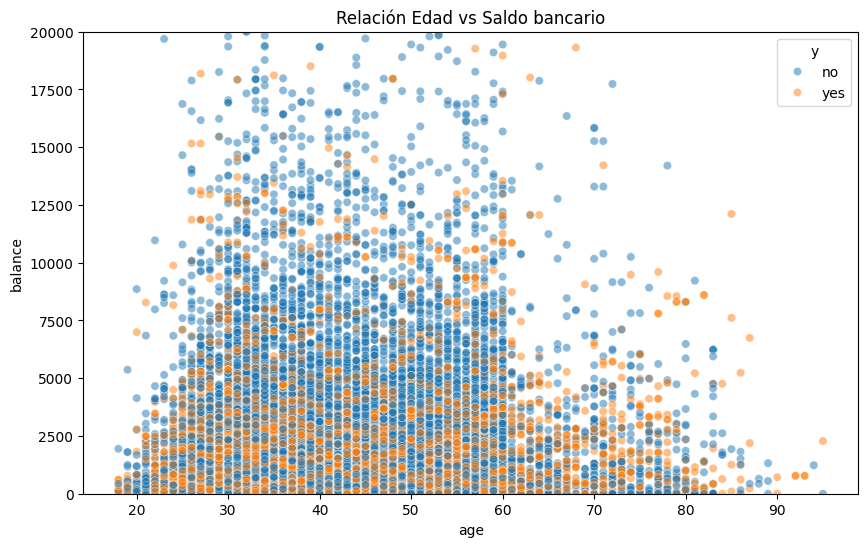

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='balance', hue='y', alpha=0.5)
plt.title('Relación Edad vs Saldo bancario')
plt.ylim(0, 20000)
plt.show()

In [ ]:
df['y'] = df['y'].map({'yes': 1, 'no': 0})
df['default'] = df['default'].map({'yes': 1, 'no': 0})
df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
df['loan'] = df['loan'].map({'yes': 1, 'no': 0})

# Selección manual de variables y dummies
# Seleccionamos las que hemos visto que importan + resto
df_final = pd.get_dummies(df, drop_first=True)

# Split
X = df_final.drop(columns=['y'])
y = df_final['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Definimos un grid razonado
params = {
    'max_depth': [3, 5, 10],
    'min_samples_leaf': [10, 20, 50]
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), params, scoring='f1', cv=5)
grid.fit(X_train, y_train)

# Evaluación del mejor árbol
y_pred_tree = grid.best_estimator_.predict(X_test)

In [9]:
print("RESULTADOS REGRESIÓN LOGÍSTICA")
print(classification_report(y_test, y_pred_lr))

print("\nRESULTADOS ÁRBOL OPTIMIZADO")
print(classification_report(y_test, y_pred_tree))
print(f"Mejores parámetros: {grid.best_params_}")

RESULTADOS REGRESIÓN LOGÍSTICA
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.64      0.35      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043


RESULTADOS ÁRBOL OPTIMIZADO
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7985
           1       0.60      0.39      0.47      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.68      0.71      9043
weighted avg       0.88      0.90      0.89      9043

Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 20}


## CONCLUSIÓN
El Árbol es el ganador. ¿Por qué? Porque la Regresión Logística es muy miedosa y solo apuesta por el "sí" cuando está segurísima. El Árbol, al combinar variables (como "duración larga" + "mes correcto"), encuentra a un 10% más de clientes interesados que la regresión ignoraba. Para el banco, eso es dinero directo en caja.